# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Imports

In [3]:
import datahandler
import plotter
import utils

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Constants

In [4]:
data_preprocessor = datahandler.DataPreprocessorOUS_V2()
data_preprocessor.execute()

data_loader = datahandler.DataLoader(datahandler.DataPreprocessorOUS_V2)
data_loader.execute(clean=False, processed=False, enhanced=False)


Enhancing dataset: 100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


# Methods

In [ ]:
def count_wrong_timestamps(dataframe: pd.DataFrame):
    datetime_columns = [
        "time_call_received", "time_incident_created", "time_resource_appointed",
        "time_ambulance_dispatch_to_scene", "time_ambulance_arrived_at_scene", "time_ambulance_dispatch_to_hospital",
        "time_ambulance_arrived_at_hospital", "time_ambulance_available"
    ]

    # Count violations for each pair of datetime columns
    for i in range(len(datetime_columns) - 1):
        first_col = datetime_columns[i]
        second_col = datetime_columns[i + 1]
        
        # Count where the first date is after the second date
        count = dataframe[dataframe[first_col] > dataframe[second_col]].shape[0]
        print(f"{first_col} to {second_col}: {count}")


In [ ]:
def find_first_problematic_row(dataframe: pd.DataFrame):
    # Convert columns to datetime if they're not already
    dataframe['time_call_received'] = pd.to_datetime(dataframe['time_call_received'])
    dataframe['time_incident_created'] = pd.to_datetime(dataframe['time_incident_created'])

    # Find the first row where time_call_received is after time_incident_created
    problematic_rows = dataframe[dataframe['time_call_received'] > dataframe['time_incident_created']]
    if not problematic_rows.empty:
        first_problematic_index = problematic_rows.index[0]
        print(f"First problematic row index: {first_problematic_index}")
        return first_problematic_index
    else:
        print("No problematic rows found.")
        return None


In [5]:
def outlier_plotting(
    dataframe: pd.DataFrame,
    column_start: str,
    column_end: str,
    triage_impression: str = None,
    log_scale: bool = False,
    IQR_multiplier: float = 1.5,
    z_score_threshold: float = 3,
    bounds_to_use: str = "z",
    cancelled: bool = False,
    percentage_threshold: float = None
):
    plotter.plot_time_difference_distribution(
        dataframe,
        column_start,
        column_end,
        triage_impression,
        log_scale,
        cancelled,
        percentage_threshold
    )
    if percentage_threshold is not None:
        plotter.plot_percentage_below_threshold_per_hour(
            dataframe,
            column_start,
            column_end,
            percentage_threshold,
            triage_impression,
            cancelled
        )

    before_size = dataframe.shape[0]

    dataframe = data_preprocessor._drop_outside_bounds(
        dataframe,
        column_start,
        column_end,
        triage_impression,
        z_score_threshold,
        IQR_multiplier,
        bounds_to_use,
        cancelled,
        verbose=True
    )

    plotter.plot_time_difference_distribution(
        dataframe,
        column_start,
        column_end,
        triage_impression,
        log_scale,
        cancelled,
        percentage_threshold
    )
    if percentage_threshold is not None:
        plotter.plot_percentage_below_threshold_per_hour(
            dataframe,
            column_start,
            column_end,
            percentage_threshold,
            triage_impression,
            cancelled
        )

    print(f"\n\nDropped {before_size - dataframe.shape[0]} ({((before_size - dataframe.shape[0]) / before_size) * 100}%) rows")


# Main

In [ ]:
count_wrong_timestamps(data_loader.processed_incidents_df)


In [ ]:
dataframe = data_preprocessor._remove_duplicates(data_loader.processed_incidents_df)
dataframe = data_preprocessor._remove_incomplete_years(dataframe)
dataframe = data_preprocessor._remove_outside_region(dataframe)
dataframe = data_preprocessor._remove_other_resource_types(dataframe)
dataframe = data_preprocessor._count_resources_sent(dataframe)
dataframe = data_preprocessor._remove_extra_resources(dataframe)

dataframe = dataframe.sort_values(by="time_call_received")


In [ ]:
count_wrong_timestamps(dataframe)


In [ ]:
dataframe["triage_impression_during_call"].value_counts()


In [ ]:
dataframe = data_preprocessor._remove_other_triage_impressions(dataframe)


In [ ]:
print(dataframe["triage_impression_during_call"].value_counts())

dataframe.info()


In [ ]:
count_wrong_timestamps(dataframe)


In [ ]:
dataframe = data_preprocessor._remove_wrong_timestamps(dataframe)


In [ ]:
dataframe["triage_impression_during_call"].value_counts()


In [ ]:
count_wrong_timestamps(dataframe)


In [ ]:
dataframe = data_preprocessor._fix_timestamps(dataframe)


In [ ]:
count_wrong_timestamps(dataframe)


In [6]:
data_loader.execute(clean=False, processed=True, enhanced=False)

dataframe = data_preprocessor._remove_duplicates(data_loader.processed_incidents_df)
dataframe = data_preprocessor._remove_incomplete_years(dataframe)
dataframe = data_preprocessor._remove_outside_region(dataframe)
dataframe = data_preprocessor._remove_other_resource_types(dataframe)
dataframe = data_preprocessor._count_resources_sent(dataframe)
dataframe = data_preprocessor._remove_extra_resources(dataframe)
dataframe = data_preprocessor._remove_other_triage_impressions(dataframe)
dataframe = data_preprocessor._remove_wrong_timestamps(dataframe)
dataframe = data_preprocessor._fix_timestamps(dataframe)
dataframe = data_preprocessor._remove_na(dataframe)


Loading dataset: 100%|██████████| 2/2 [00:26<00:00, 13.36s/it]


# A Incidents

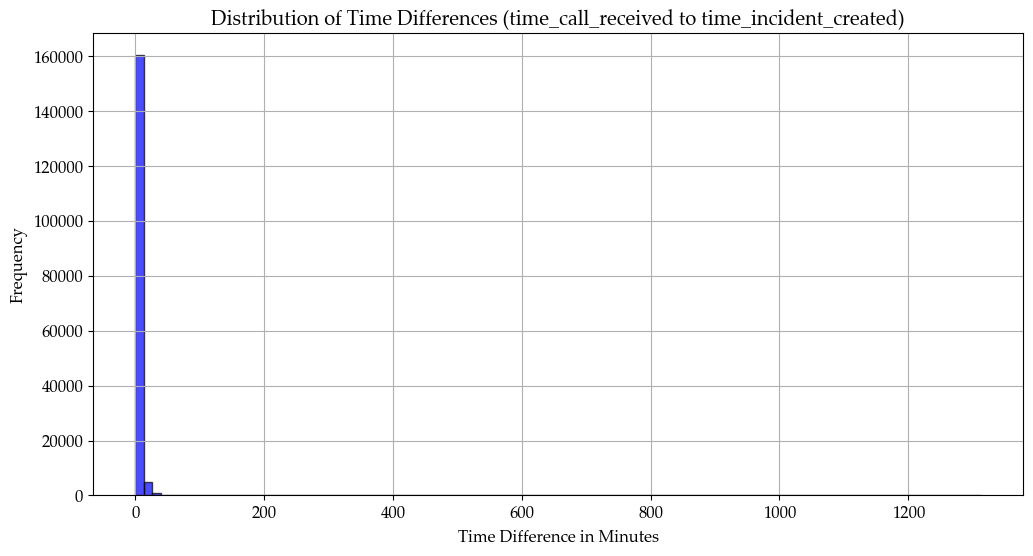

Mean time difference: 3.655238329224877 minutes
Median time difference: 1.9166666666666667 minutes
Standard deviation of time difference: 11.221117487691128 minutes
Maximum time difference: 1312.4666666666667 minutes
Minimum time difference: 0.0 minutes
Percentage of time differences below 1.5 minutes: 40.70%


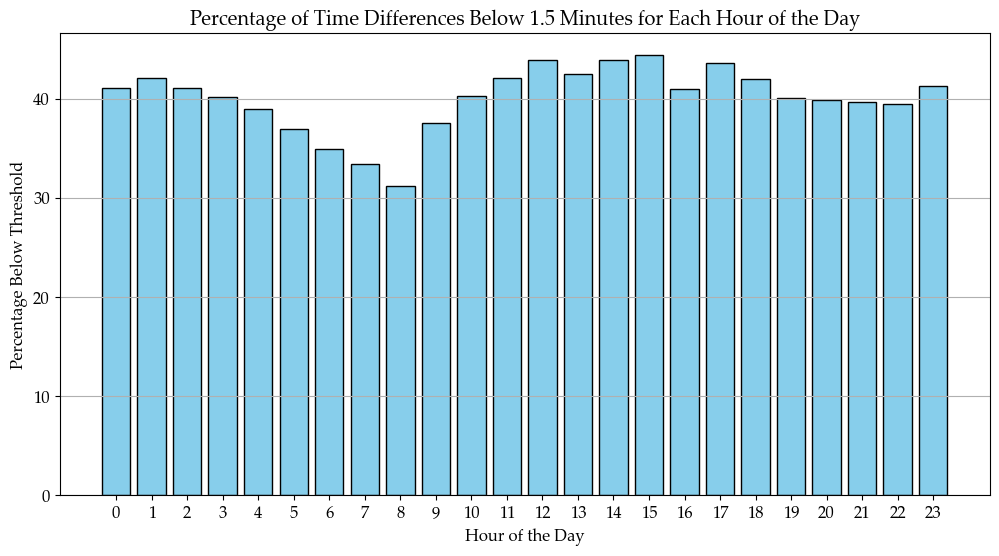

Suggested IQR upper bound for dropping rows: 1719.27 seconds
Suggested IQR lower bound for dropping rows: 5.97 seconds
Suggested Z-Score upper bound for dropping rows: 630.1 seconds
Suggested Z-Score lower bound for dropping rows: 17.06 seconds


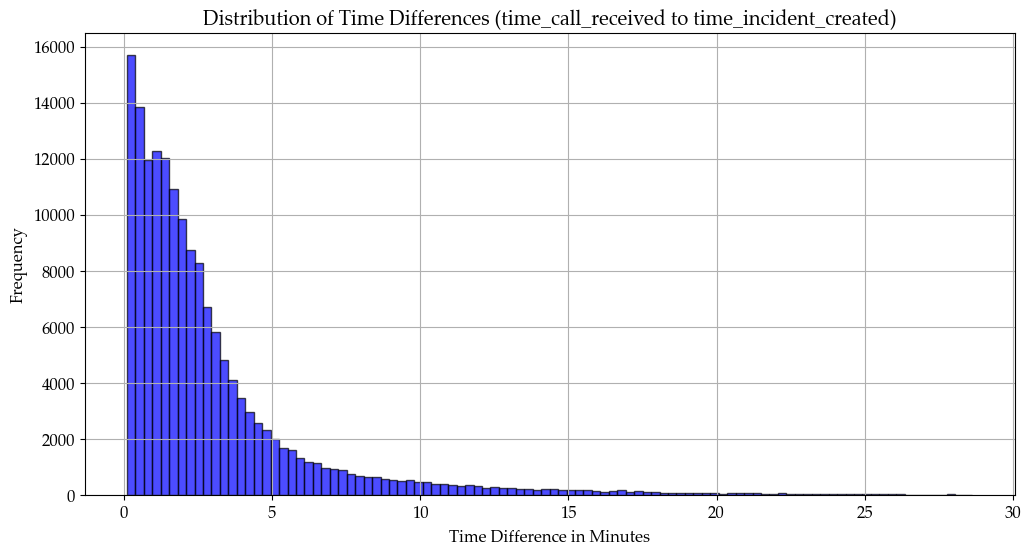

Mean time difference: 3.0946455452896817 minutes
Median time difference: 1.9333333333333333 minutes
Standard deviation of time difference: 3.724137904895824 minutes
Maximum time difference: 28.633333333333333 minutes
Minimum time difference: 0.1 minutes
Percentage of time differences below 1.5 minutes: 40.01%


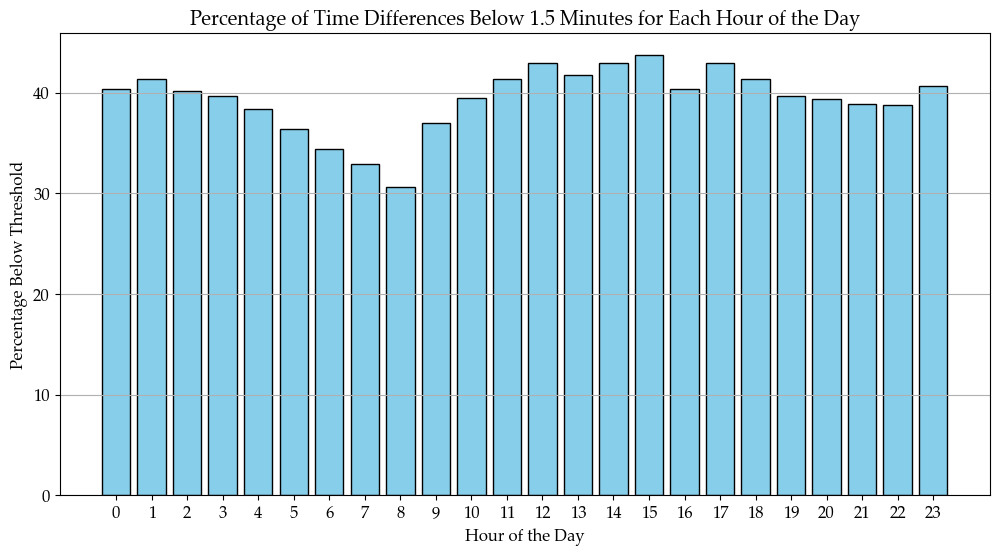



Dropped 4322 (1.485407129404325%) rows


In [7]:
outlier_plotting(
    dataframe,
    triage_impression="A",
    column_start="time_call_received",
    column_end="time_incident_created",
    log_scale=False,
    IQR_multiplier=1.5,
    z_score_threshold=1.5,
    bounds_to_use="iqr",
    percentage_threshold=1.5
)


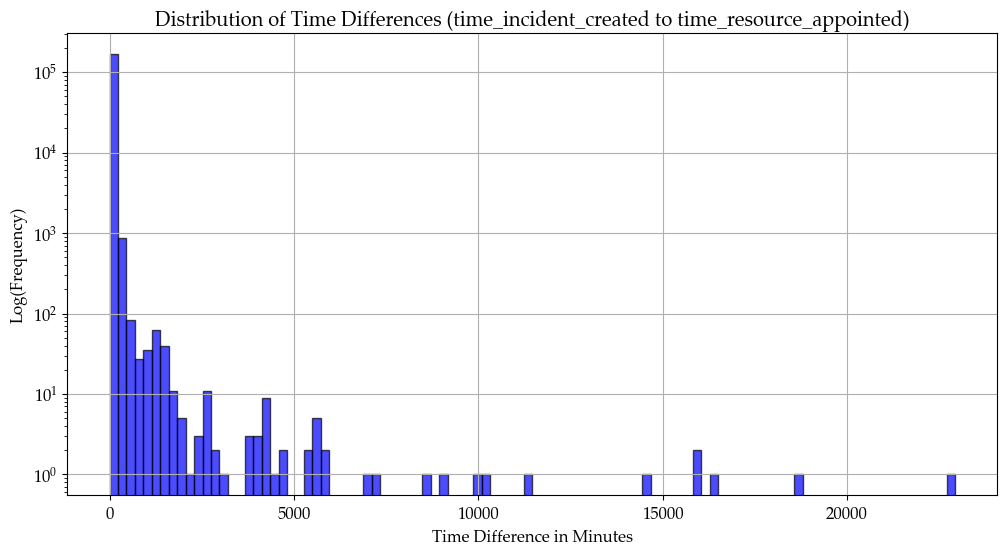

Mean time difference: 20.56897931075781 minutes
Median time difference: 3.65 minutes
Standard deviation of time difference: 148.44956566645465 minutes
Maximum time difference: 22922.916666666668 minutes
Minimum time difference: 0.0 minutes
Percentage of time differences below 2 minutes: 35.21%


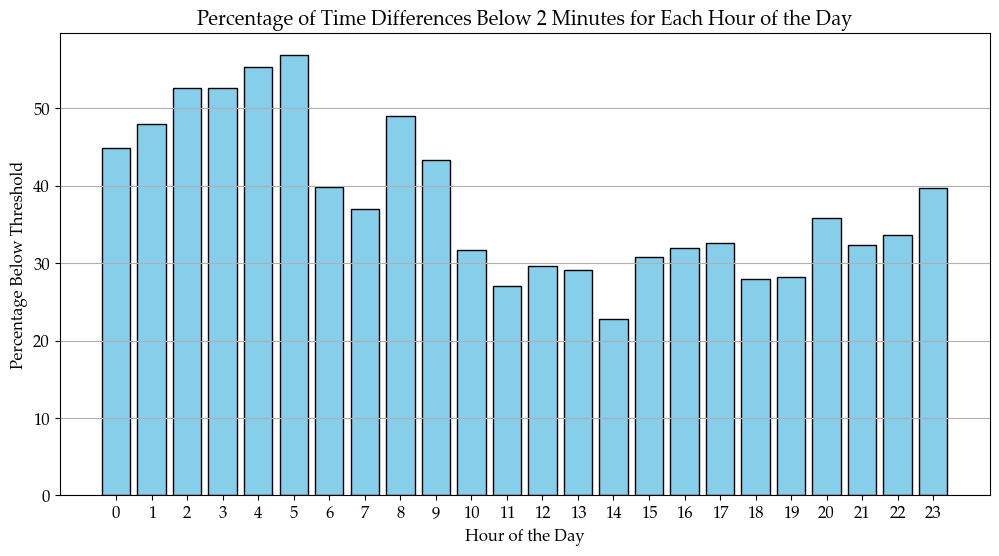

Suggested IQR upper bound for dropping rows: 31158.2 seconds
Suggested IQR lower bound for dropping rows: 1.19 seconds
Suggested Z-Score upper bound for dropping rows: 3351.66 seconds
Suggested Z-Score lower bound for dropping rows: 19.74 seconds


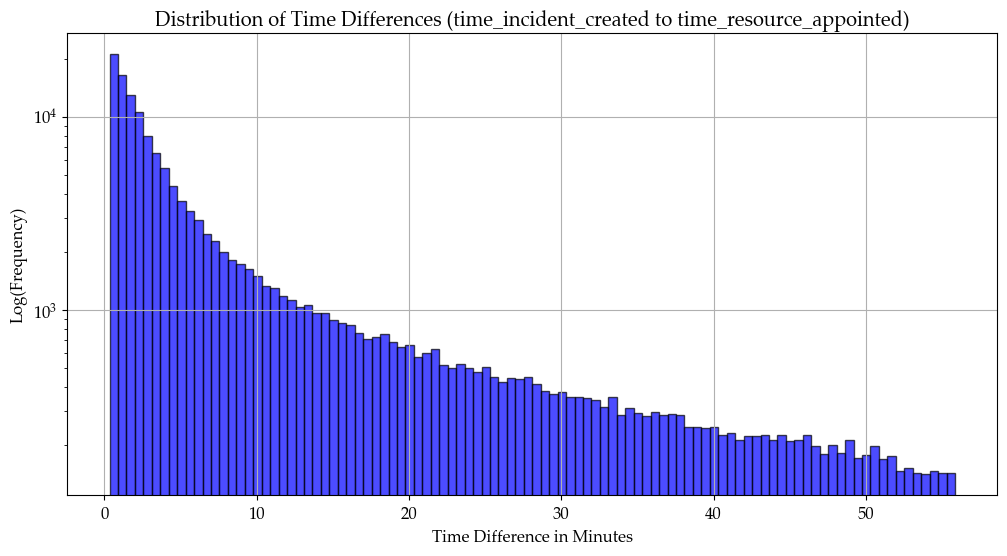

Mean time difference: 8.46637871752235 minutes
Median time difference: 3.3666666666666667 minutes
Standard deviation of time difference: 11.470058460649765 minutes
Maximum time difference: 55.85 minutes
Minimum time difference: 0.3333333333333333 minutes
Percentage of time differences below 2 minutes: 35.16%


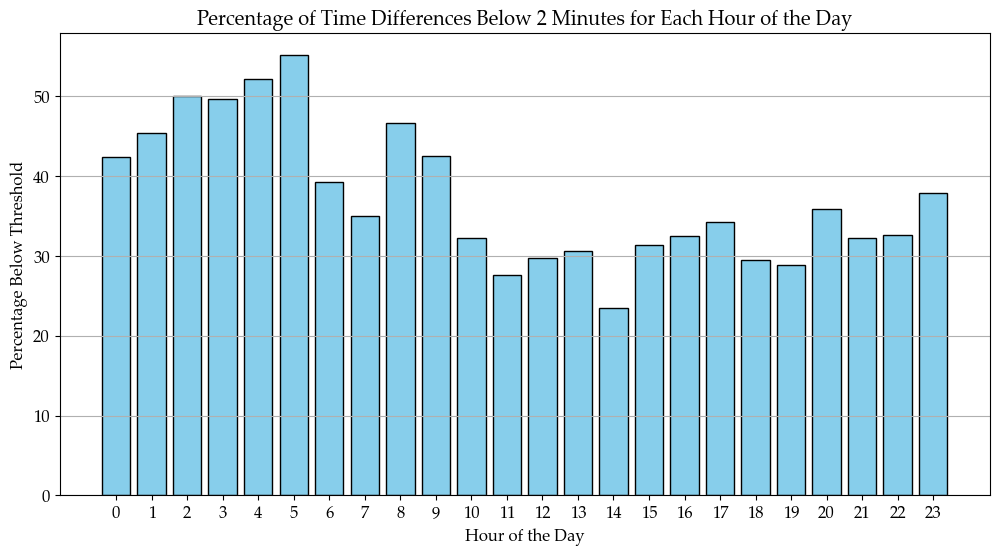



Dropped 22062 (7.582381325524808%) rows


In [9]:
outlier_plotting(
    dataframe,
    triage_impression="A",
    column_start="time_incident_created",
    column_end="time_resource_appointed",
    log_scale=True,
    z_score_threshold=1.5,
    bounds_to_use="z",
    percentage_threshold=2
)


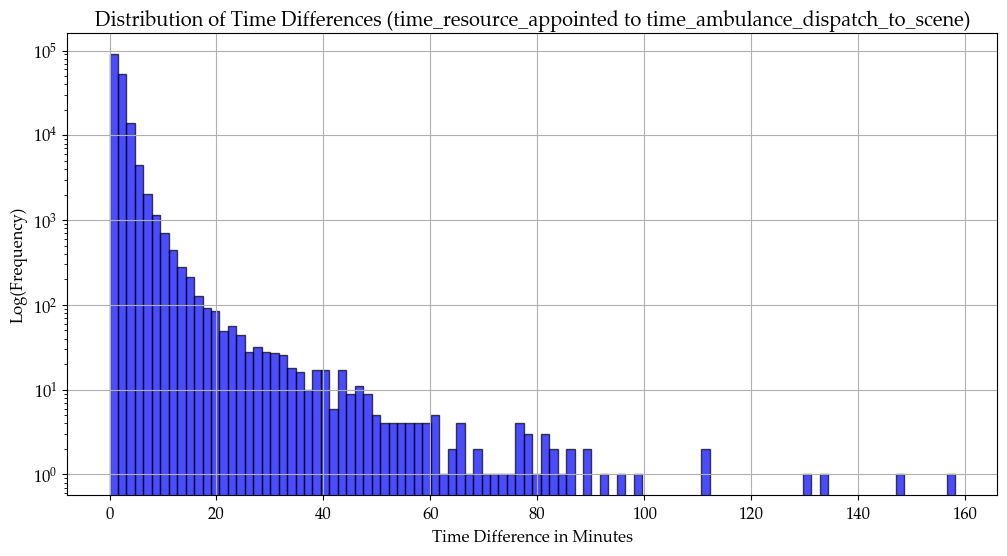

Mean time difference: 1.852340888449754 minutes
Median time difference: 1.45 minutes
Standard deviation of time difference: 2.9350216218296246 minutes
Maximum time difference: 158.16666666666666 minutes
Minimum time difference: 0.0 minutes
Percentage of time differences below 1 minutes: 39.54%


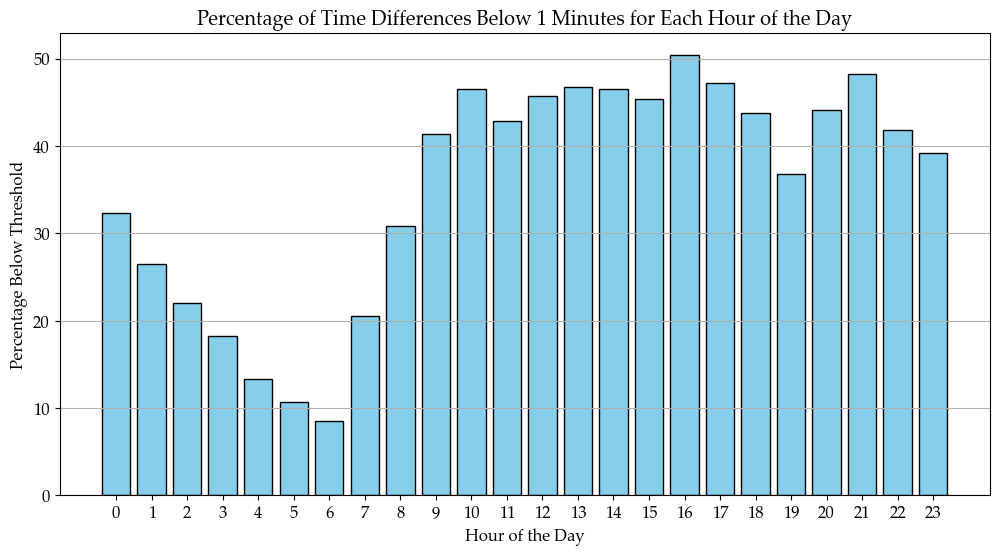

Suggested IQR upper bound for dropping rows: 6089.43 seconds
Suggested IQR lower bound for dropping rows: -0.71 seconds
Suggested Z-Score upper bound for dropping rows: 4132.33 seconds
Suggested Z-Score lower bound for dropping rows: -0.39 seconds


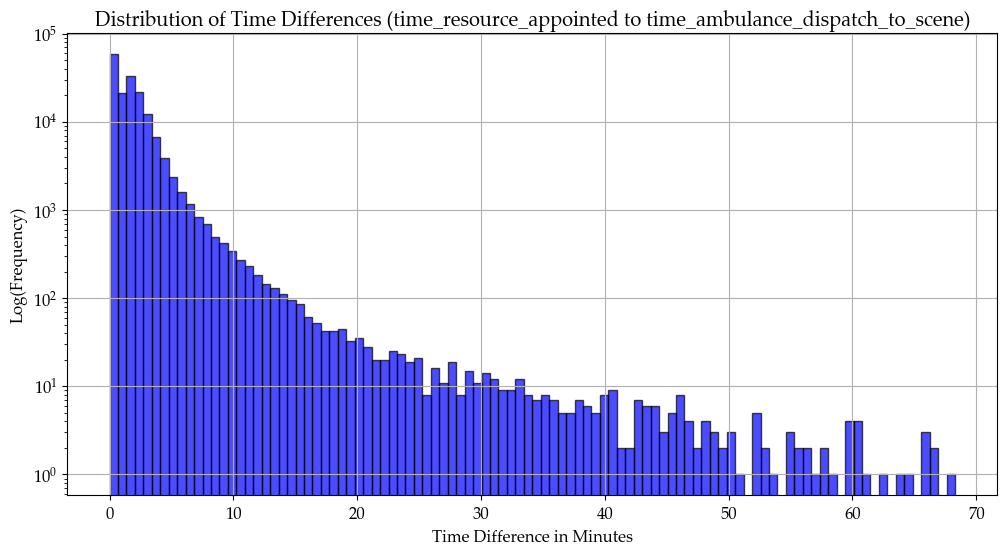

Mean time difference: 1.835297141682089 minutes
Median time difference: 1.45 minutes
Standard deviation of time difference: 2.646978959335752 minutes
Maximum time difference: 68.28333333333333 minutes
Minimum time difference: 0.0 minutes
Percentage of time differences below 1 minutes: 39.55%


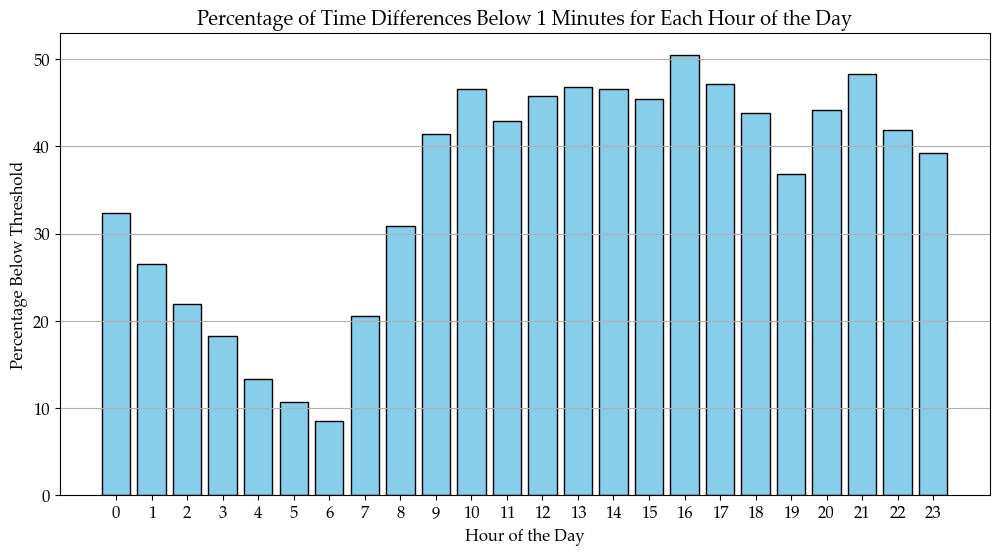



Dropped 32 (0.010997924141818232%) rows


In [10]:
outlier_plotting(
    dataframe,
    triage_impression="A",
    column_start="time_resource_appointed",
    column_end="time_ambulance_dispatch_to_scene",
    log_scale=True,
    z_score_threshold=3,
    bounds_to_use="z",
    percentage_threshold=1
)


In [ ]:
outlier_plotting(
    dataframe,
    triage_impression="A",
    column_start="time_ambulance_dispatch_to_scene",
    column_end="time_ambulance_arrived_at_scene",
    log_scale=True,
    z_score_threshold=3,
    bounds_to_use="z"
)


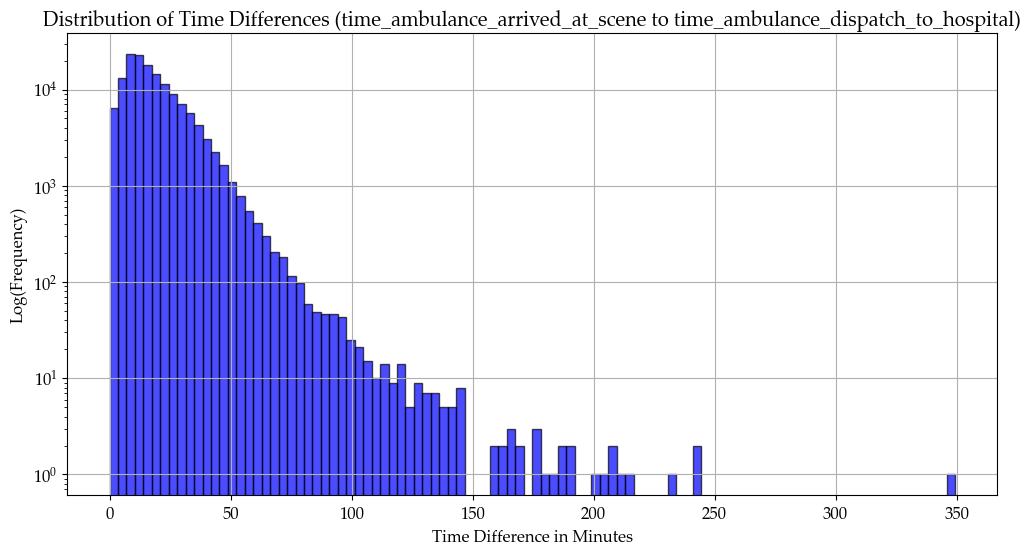

Mean time difference: 18.58870412844037 minutes
Median time difference: 15.366666666666667 minutes
Standard deviation of time difference: 13.226895350477328 minutes
Maximum time difference: 349.28333333333336 minutes
Minimum time difference: 0.0 minutes
Percentage of time differences below 10 minutes: 27.03%


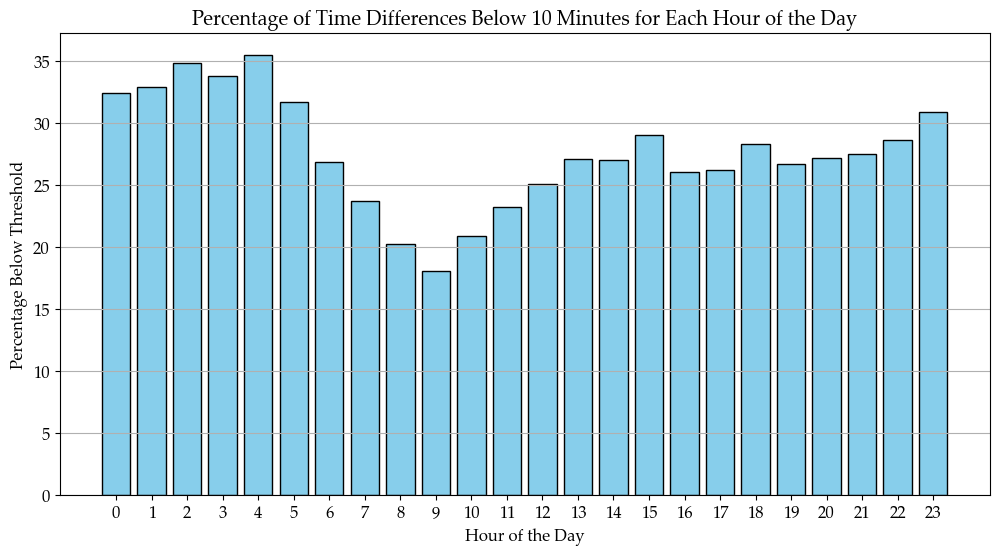

Suggested IQR upper bound for dropping rows: 6100.25 seconds
Suggested IQR lower bound for dropping rows: 138.39 seconds
Suggested Z-Score upper bound for dropping rows: 12299.91 seconds
Suggested Z-Score lower bound for dropping rows: 51.95 seconds


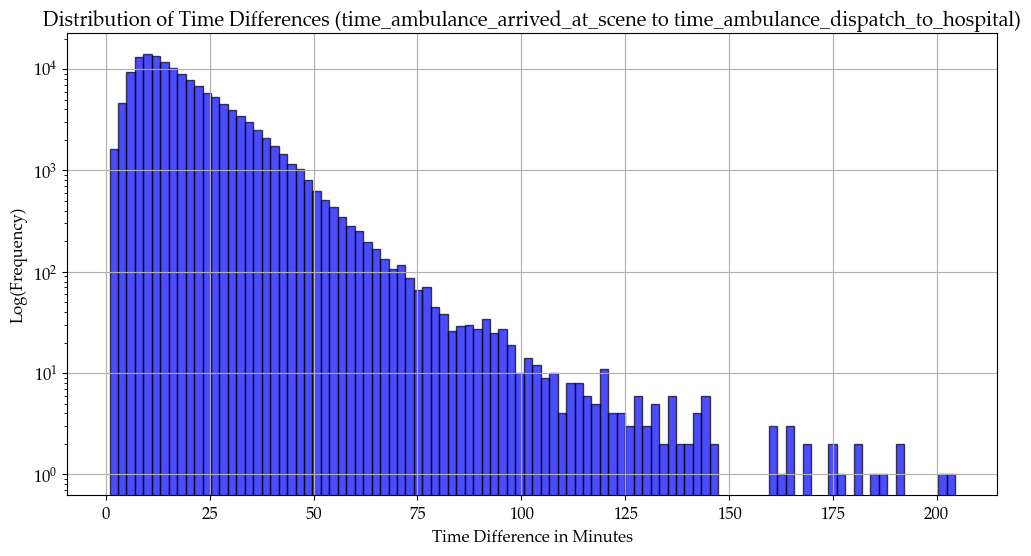

Mean time difference: 19.087117178420524 minutes
Median time difference: 15.75 minutes
Standard deviation of time difference: 12.933726479849925 minutes
Maximum time difference: 204.4 minutes
Minimum time difference: 0.8666666666666667 minutes
Percentage of time differences below 10 minutes: 25.02%


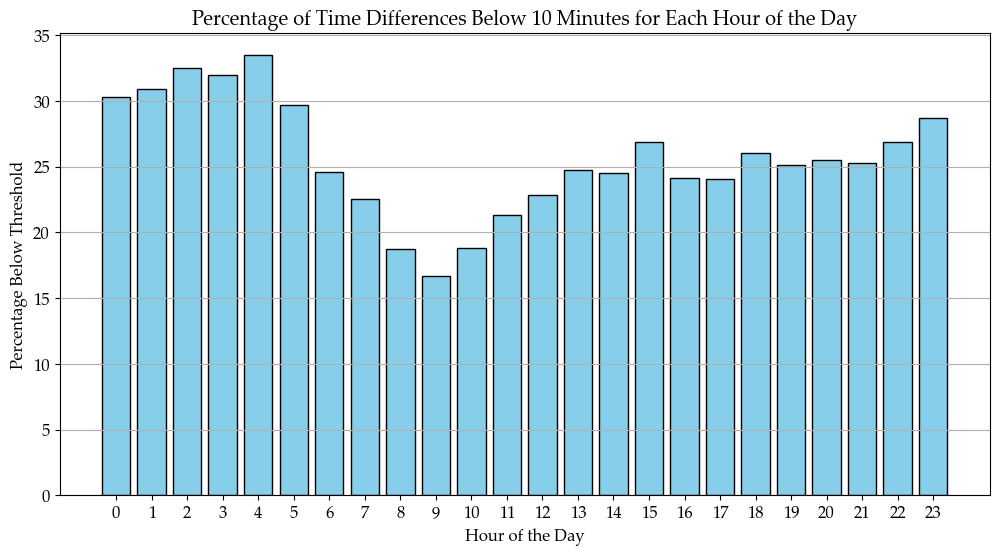



Dropped 3947 (1.3565252058673924%) rows


In [13]:
outlier_plotting(
    dataframe,
    triage_impression="A",
    column_start="time_ambulance_arrived_at_scene",
    column_end="time_ambulance_dispatch_to_hospital",
    log_scale=True,
    z_score_threshold=2.5,
    bounds_to_use="z",
    percentage_threshold=30
)


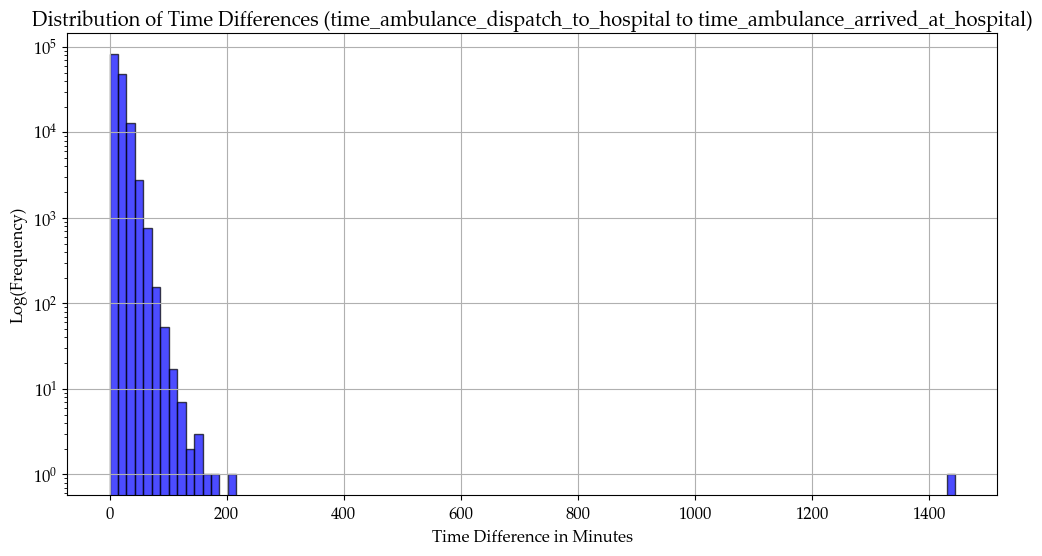

Mean time difference: 15.896498197903014 minutes
Median time difference: 13.166666666666666 minutes
Standard deviation of time difference: 11.478346486146979 minutes
Maximum time difference: 1444.9333333333334 minutes
Minimum time difference: 0.0 minutes
Percentage of time differences below 60 minutes: 99.45%


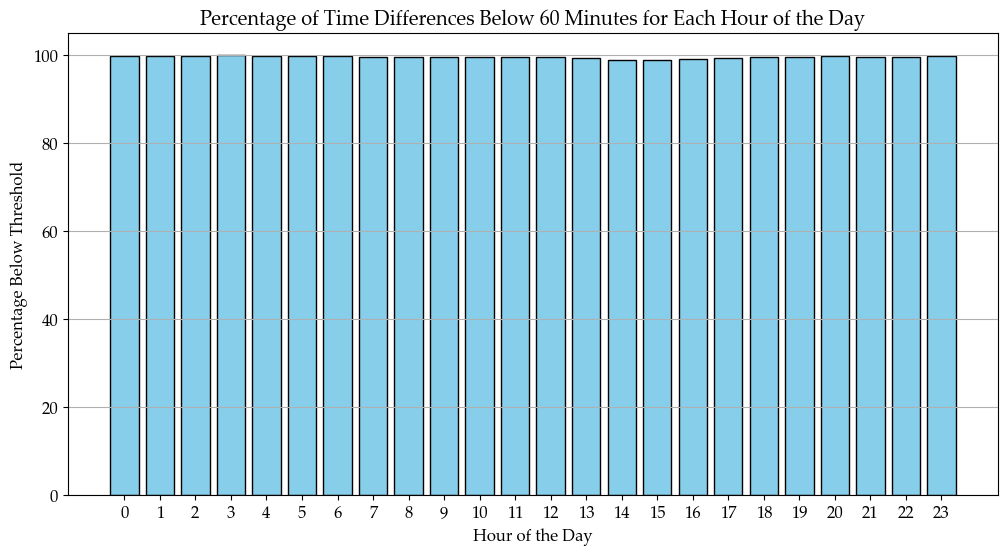

Suggested IQR upper bound for dropping rows: 4237.06 seconds
Suggested IQR lower bound for dropping rows: 144.86 seconds
Suggested Z-Score upper bound for dropping rows: 8280.83 seconds
Suggested Z-Score lower bound for dropping rows: 67.59 seconds


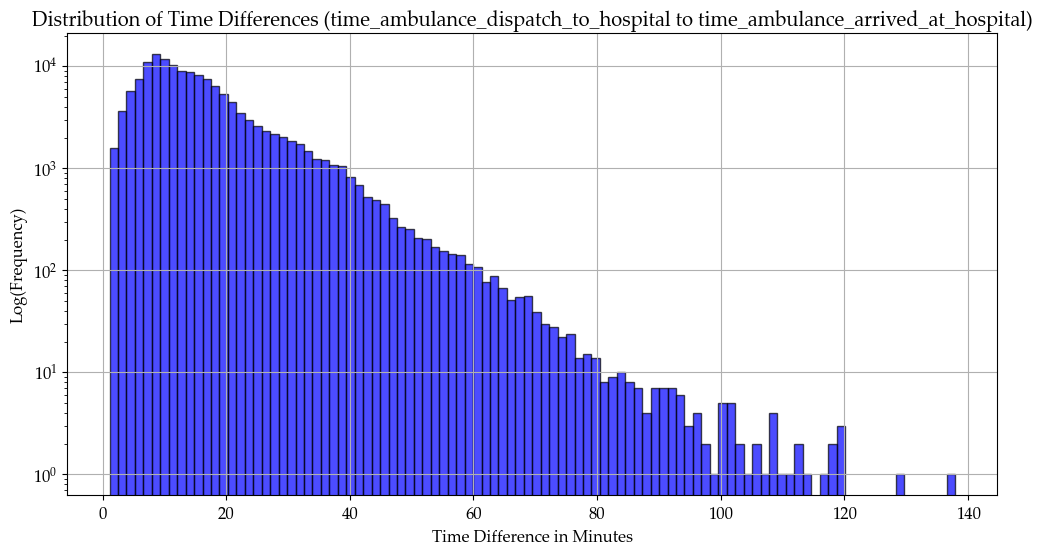

Mean time difference: 16.034431322803847 minutes
Median time difference: 13.266666666666667 minutes
Standard deviation of time difference: 10.745015903651653 minutes
Maximum time difference: 137.88333333333333 minutes
Minimum time difference: 1.1333333333333333 minutes
Percentage of time differences below 60 minutes: 99.45%


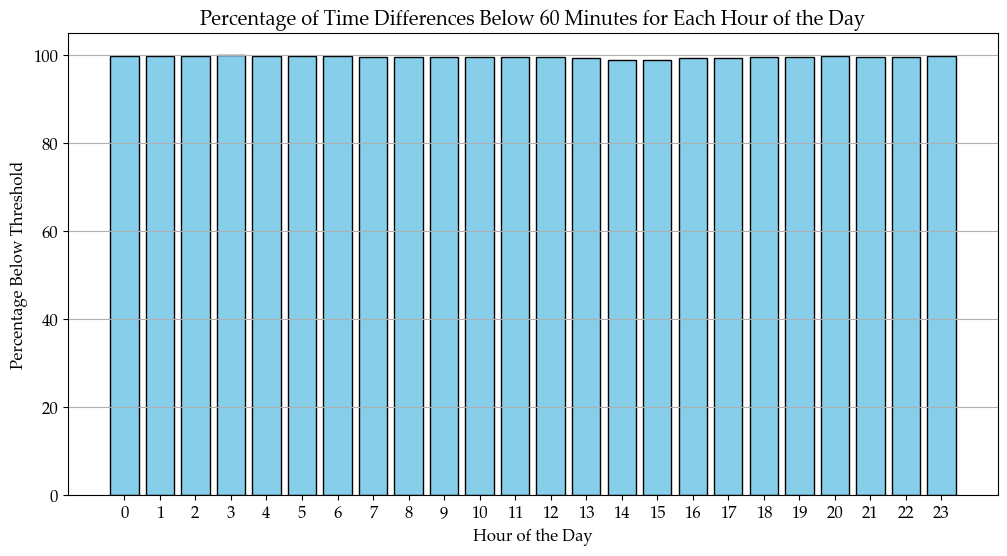



Dropped 1443 (0.4959376417701159%) rows


In [14]:
outlier_plotting(
    dataframe,
    triage_impression="A",
    column_start="time_ambulance_dispatch_to_hospital",
    column_end="time_ambulance_arrived_at_hospital",
    log_scale=True,
    z_score_threshold=3,
    bounds_to_use="z",
    percentage_threshold=60
)


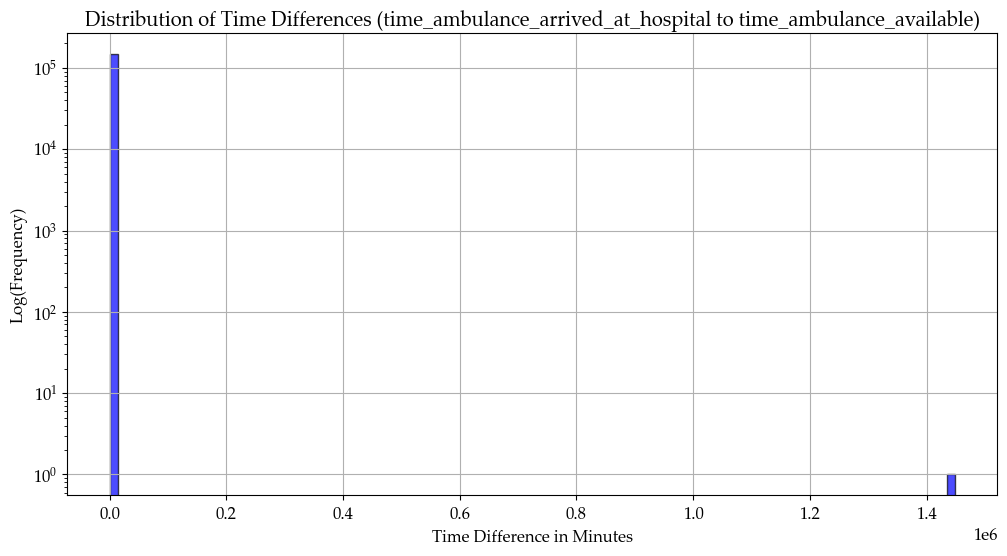

Mean time difference: 26.180505724843457 minutes
Median time difference: 13.366666666666667 minutes
Standard deviation of time difference: 3784.977112861286 minutes
Maximum time difference: 1448664.0666666667 minutes
Minimum time difference: 0.0 minutes
Percentage of time differences below 3 minutes: 1.88%


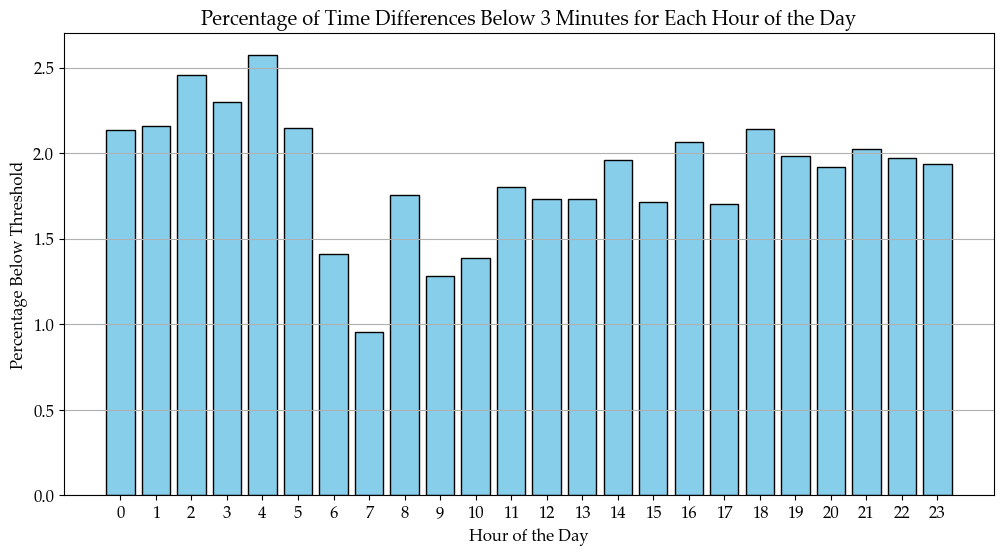

Suggested IQR upper bound for dropping rows: 3186.8 seconds
Suggested IQR lower bound for dropping rows: 202.48 seconds
Suggested Z-Score upper bound for dropping rows: 7435.67 seconds
Suggested Z-Score lower bound for dropping rows: 79.09 seconds


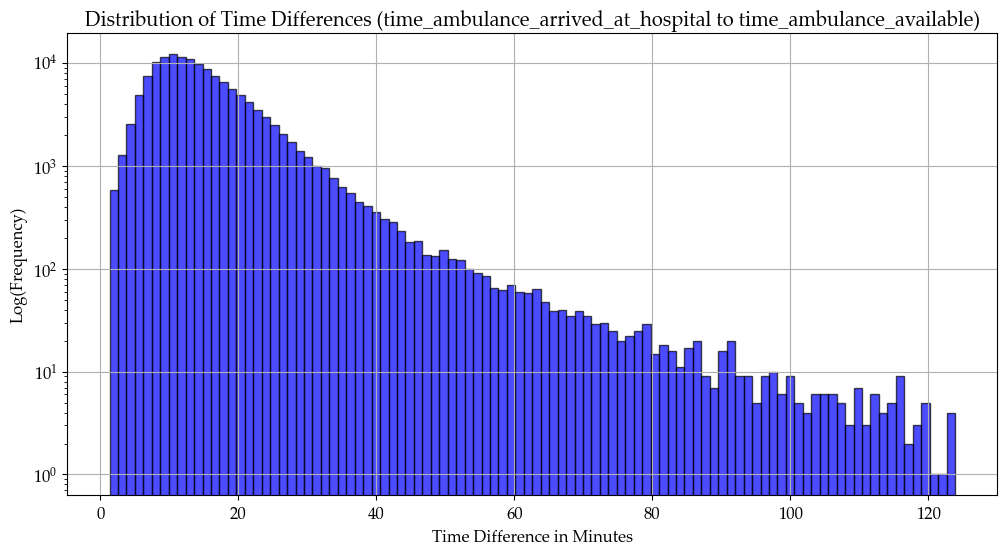

Mean time difference: 15.615779070169971 minutes
Median time difference: 13.45 minutes
Standard deviation of time difference: 9.558550710457729 minutes
Maximum time difference: 123.86666666666666 minutes
Minimum time difference: 1.3333333333333333 minutes
Percentage of time differences below 3 minutes: 0.65%


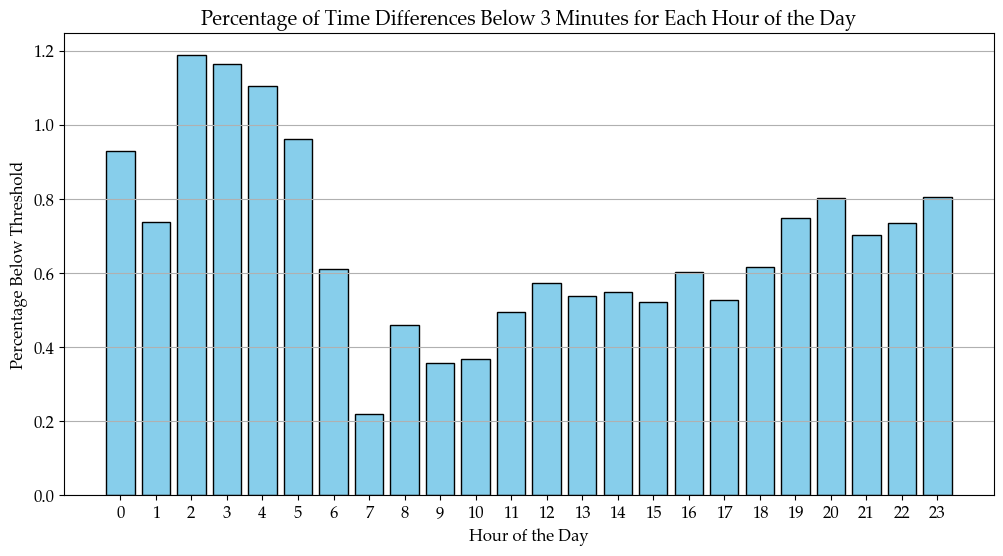



Dropped 2061 (0.7083350517589805%) rows


In [16]:
outlier_plotting(
    dataframe,
    triage_impression="A",
    column_start="time_ambulance_arrived_at_hospital",
    column_end="time_ambulance_available",
    log_scale=True,
    z_score_threshold=3,
    bounds_to_use="z"
)


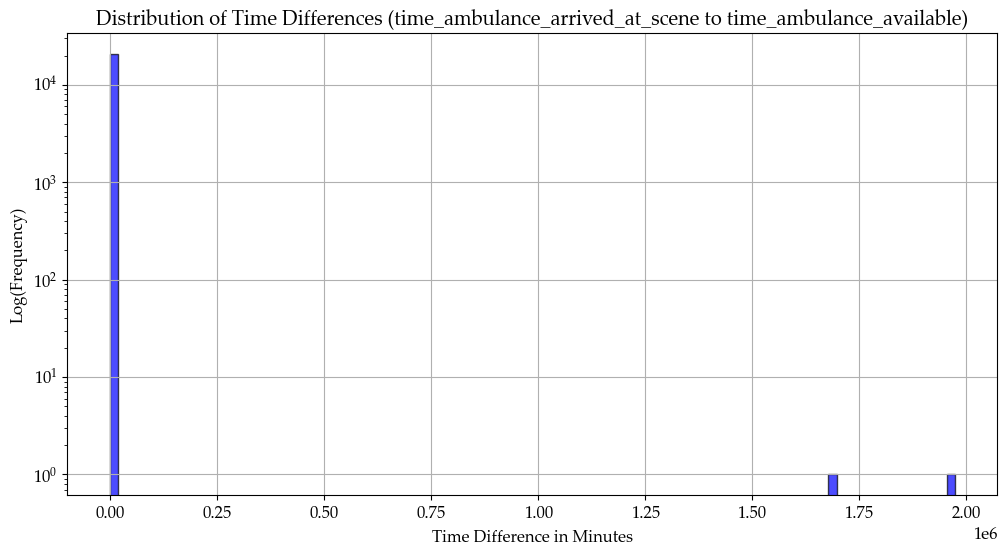

Mean time difference: 211.53256744231425 minutes
Median time difference: 29.633333333333333 minutes
Standard deviation of time difference: 18114.14763703207 minutes
Maximum time difference: 1974294.1666666667 minutes
Minimum time difference: -1975.65 minutes
Percentage of time differences below 30 minutes: 50.77%


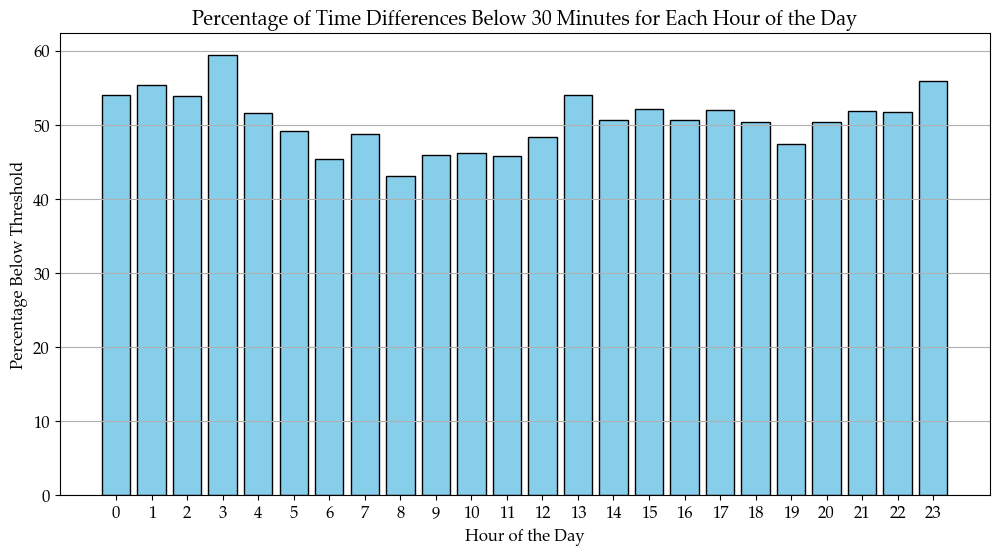

c:\Users\sindr\Documents\Emergency-Optimizers\Data-Processing\.venv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Suggested IQR upper bound for dropping rows: 10112.11 seconds
Suggested IQR lower bound for dropping rows: 269.89 seconds
Suggested Z-Score upper bound for dropping rows: 16264.59 seconds
Suggested Z-Score lower bound for dropping rows: 130.24 seconds


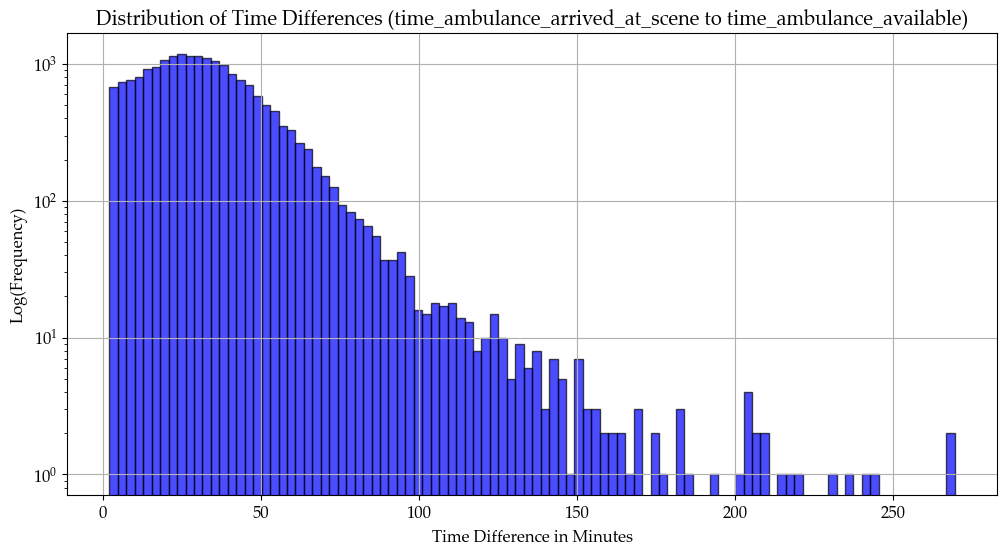

Mean time difference: 33.320966340933765 minutes
Median time difference: 30.2 minutes
Standard deviation of time difference: 21.59877868234259 minutes
Maximum time difference: 269.55 minutes
Minimum time difference: 2.183333333333333 minutes
Percentage of time differences below 30 minutes: 49.56%


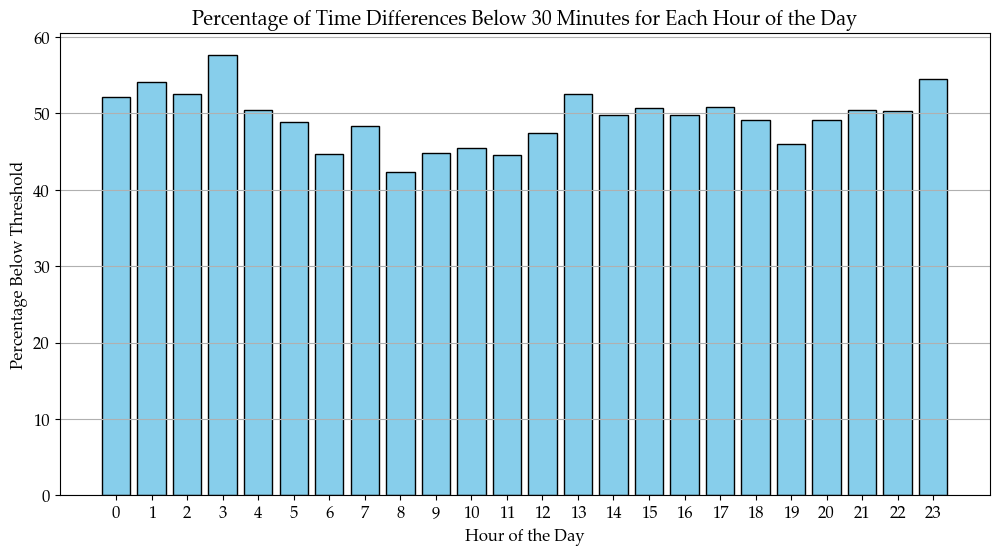



Dropped 544 (0.18696471041090995%) rows


In [17]:
outlier_plotting(
    dataframe,
    triage_impression="A",
    column_start="time_ambulance_arrived_at_scene",
    column_end="time_ambulance_available",
    log_scale=True,
    z_score_threshold=2.5,
    bounds_to_use="z",
    cancelled=True,
    percentage_threshold=30
)


In [ ]:
dataframe.shape
